<a href="https://colab.research.google.com/github/sadiashoaib415/Quantum_Computer/blob/main/Ground_State_energy_of_a_2qubit_Heisenberg_Hamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-aer qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 854.7 kB/s eta 0:00:00


In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA

In [3]:
# ------------------------------
# 1. Heisenberg Hamiltonian
# ------------------------------
H = SparsePauliOp.from_list([
    ("XX", 1.0),
    ("YY", 1.0),
    ("ZZ", 1.0)
])

# ------------------------------
# 2. Hard custom hardware-efficient ansatz
# ------------------------------
def hard_ansatz(params):
    qc = QuantumCircuit(2)
    # Layer 1: Rotations
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rz(params[2], 0)
    qc.rx(params[3], 1)
    qc.ry(params[4], 1)
    qc.rz(params[5], 1)
    # Entanglement
    qc.cx(0, 1)
    qc.cx(1, 0)
    # Layer 2: Final Rotations
    qc.ry(params[6], 0)
    qc.ry(params[7], 1)
    return qc

# ------------------------------
# 3. Build a realistic noise model
# ------------------------------
noise_model = NoiseModel()
p1, p2 = 0.02, 0.05
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ["rx","ry","rz"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ["cx"])

simulator = AerSimulator(noise_model=noise_model)

# ------------------------------
# 4. Expectation estimation with folding
# ------------------------------
def estimate_energy(params, scale_noise=1):
    total = 0.0
    for pauli, coeff in zip(H.paulis, H.coeffs):
        qc = hard_ansatz(params)

        # Rotate into measurement basis
        label = pauli.to_label()
        for i, p in enumerate(label):
            if p == "X": qc.h(i)
            elif p == "Y": qc.sdg(i); qc.h(i)

        # Proper Unitary Folding for ZNE: U -> U(U^dag U)^n
        # scale_noise 1 = U, scale_noise 3 = U (U^dag U)
        base_circuit = qc.copy()
        if scale_noise > 1:
            num_folds = (scale_noise - 1) // 2
            for _ in range(num_folds):
                qc.compose(base_circuit.inverse(), inplace=True)
                qc.compose(base_circuit, inplace=True)

        qc.measure_all()
        tqc = transpile(qc, simulator, optimization_level=0)
        counts = simulator.run(tqc, shots=4000).result().get_counts()

        exp = 0
        for bitstring, c in counts.items():
            # Standard parity calculation for <Pauli>
            parity = (-1)**(bitstring.count('1') % 2)
            exp += parity * c

        total += coeff * (exp / 4000)

    return np.real(total)

# ------------------------------
# 5. Optimization & 6. Optimizer
# ------------------------------
optimizer = COBYLA(maxiter=80)
x0 = np.random.uniform(0, 2*np.pi, 8)

result = optimizer.minimize(fun=lambda x: estimate_energy(x, 1), x0=x0)

print("\nNoisy VQE energy:")
print(result.fun)

best_params = result.x

# ------------------------------
# 7. Zero-Noise Extrapolation
# ------------------------------
E1 = estimate_energy(best_params, scale_noise=1)
E3 = estimate_energy(best_params, scale_noise=3)
E0 = (3*E1 - E3)/2

print("\nZNE values")
print("Noise scale 1 :", E1)
print("Noise scale 3 :", E3)
print("Extrapolated  :", E0)

# ------------------------------
# 8. Exact reference (hard check)
# ------------------------------
exact = np.min(np.linalg.eigvals(H.to_matrix()))
print("\nExact ground energy:")
print(np.real(exact))


Noisy VQE energy:
-0.5655

ZNE values
Noise scale 1 : -0.5515
Noise scale 3 : -0.23850000000000002
Extrapolated  : -0.7080000000000001

Exact ground energy:
-3.0000000000000004


In [2]:
# 1. Heisenberg Hamiltonian
H = SparsePauliOp.from_list([("XX", 1.0), ("YY", 1.0), ("ZZ", 1.0)])

# 2. Ansatz
theta = [0.1] * 8 # Initialize parameters
def hard_ansatz(params):
    qc = QuantumCircuit(2)
    for i in range(2):
        qc.rx(params[i*3], i)
        qc.ry(params[i*3+1], i)
        qc.rz(params[i*3+2], i)
    qc.cx(0,1)
    qc.cx(1,0)
    qc.ry(params[6], 0)
    qc.ry(params[7], 1)
    return qc

# 3. Noise Model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ["rx","ry","rz"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ["cx"])
simulator = AerSimulator(noise_model=noise_model)

# 4. Energy Estimation
def estimate_energy(params, scale_noise=1):
    total = 0.0
    for pauli, coeff in zip(H.paulis, H.coeffs):
        qc = hard_ansatz(params)
        # Apply basis change
        for i, p in enumerate(pauli.to_label()):
            if p == "X": qc.h(i)
            elif p == "Y": qc.sdg(i); qc.h(i)

        # Simple folding for noise scaling
        full_qc = qc.copy()
        for _ in range(scale_noise - 1):
            full_qc.compose(qc.inverse(), inplace=True)
            full_qc.compose(qc, inplace=True)

        full_qc.measure_all()
        tqc = transpile(full_qc, simulator)
        counts = simulator.run(tqc, shots=4000).result().get_counts()

        # Calculate expectation
        exp = sum((1 if bin(int(k, 2)).count('1') % 2 == 0 else -1) * v for k, v in counts.items()) / 4000
        total += coeff * exp
    return np.real(total)

# 5. Optimization
optimizer = COBYLA(maxiter=80)
res = optimizer.minimize(lambda x: estimate_energy(x, 1), np.random.uniform(0, 2*np.pi, 8))

print(f"Noisy VQE energy: {res.fun}")
print(f"Extrapolated Energy: {(3*estimate_energy(res.x, 1) - estimate_energy(res.x, 3))/2}")

Noisy VQE energy: -2.2315
Extrapolated Energy: -2.29075


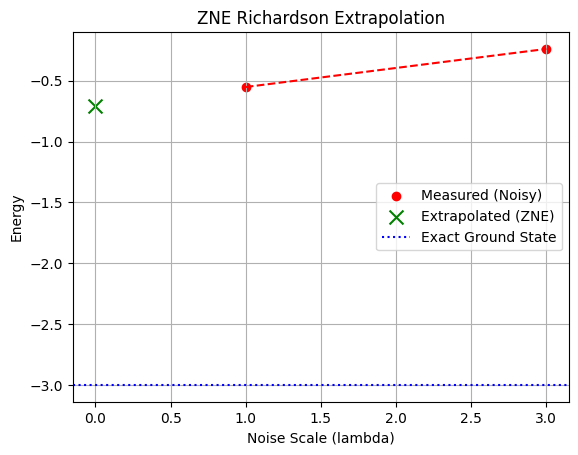

In [4]:
import matplotlib.pyplot as plt

# Data from your run
scales = [1, 3]
energies = [E1, E3] # Replace with your variables or values
extrapolated = E0    # Replace with your ZNE result

plt.scatter(scales, energies, color='red', label='Measured (Noisy)')
plt.plot(scales, energies, 'r--')
plt.scatter(0, extrapolated, color='green', marker='x', s=100, label='Extrapolated (ZNE)')
plt.axhline(y=-3.0, color='blue', linestyle=':', label='Exact Ground State')

plt.xlabel('Noise Scale (lambda)')
plt.ylabel('Energy')
plt.title('ZNE Richardson Extrapolation')
plt.legend()
plt.grid(True)
plt.show()